# 1 - Data Exploration

> In this competition, you’re challenged to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate better than Perspective’s current models. You’ll be using a dataset of comments from Wikipedia’s talk page edits. Improvements to the current model will hopefully help online discussion become more productive and respectful.

Taken from the description on the [Kaggle competition page](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge).

As I'm currently reading up on NLP classification and labelling, this seemed like a perfect challenge to explore. This is thus another case of trying out some techniques without aiming for an actually competitive model (starting three days before deadline otherwise wouldn't be the smartest thing to do).

In [69]:
import numpy as np
import pandas as pd
import zipfile

filepath =  '/Users/freddiekarlbom/.kaggle/competitions/jigsaw-toxic-comment-classification-challenge/train.csv.zip'

with zipfile.ZipFile(filepath) as zip:
    with zip.open('train.csv') as myZip:
        df = pd.read_csv(myZip) 

In [8]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [22]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


This shows that it's a binary classification and that the classes are unbalanced, i.e. there are a lot more examples in the data set that are not toxic etc. than there are that are.

## Training Data Labels

In [26]:
prediction_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [31]:
df[prediction_columns].apply(lambda x: sum(x), axis=0)

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [35]:
# Of total rows
df.shape[0]

159571

It's reasonable to assume that there will be a lot of correlation between the different labels, any severely toxic comment should by definition be toxic as well for example.

Since they are all to be predicted, this won't mean we can use them as feature. It suggests though that any model we would train that can classify some of the labels also should have some success in classify the others.

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

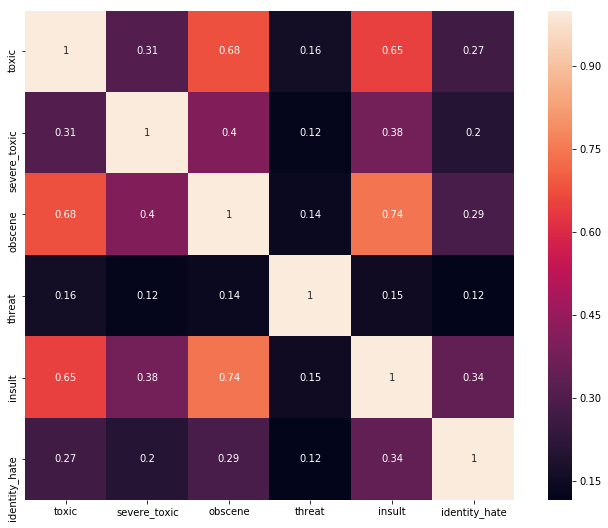

In [37]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True, annot=True);

This turns out to be the case to some extent, with obscenities and insults being the most common multilabel. Interestingly, it seems like threats are something of an exception, that doesn't correlate much with the other labels.

## Training data predictor
Let's first just look at some of the comments to get an idea of the format.

In [65]:
with pd.option_context('max_colwidth', -1):
    print(df['comment_text'][0:5].to_string(index=False))

Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27                                                                                                                                                                                                                                                                                                                                                                         
D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)                                                                                                                                                                                                                                                                     

We see that \n is used for line breaks, and that there are some other Wikipedia related metadata that seems to be included sometimes. Nothing too bad though, with some basic data cleaning we should be quite fine.